# Assignment: Research Engineer in Natural Language Processing
## RISE Research Institutes of Sweden
### Author: John Handley

To test the models with some custom input, see the last section.

We will first install the following libraries which are required at different points throughout the notebook:

In [9]:
# install libraries
!pip install transformers[torch] accelerate datasets seqeval evaluate -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 15.8 MB/s eta 0:00:00


Import all libraries:

In [10]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, DataCollatorForTokenClassification, TrainingArguments, pipeline
from datasets import load_dataset
from huggingface_hub import HfApi

import numpy as np, matplotlib.pyplot as plt, json, evaluate

# Data loading and preprocessing

## Data loading

In [26]:
# load dataset
dataset = load_dataset('Babelscape/multinerd')

# remove non-EN segments
en_dataset = dataset.filter(lambda x: x['lang'] == 'en')

# drop the lang feature/column
en_dataset = en_dataset.remove_columns('lang')

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/20 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/2678400 [00:00<?, ? examples/s]

Filter:   0%|          | 0/334800 [00:00<?, ? examples/s]

Filter:   0%|          | 0/335986 [00:00<?, ? examples/s]

## Preprocessing
As per the instructions, **System A** will be trained on 'en_dataset', where the non-English segments have been filtered out.

For **System B**, we need to set to '0' those tags that are not in the following categories:
*   O : 0
*   PER : 1, 2
*   ORG : 3, 4
*   LOC :  5, 6
*   ANIM : 7, 8
*   DIS :  13, 14

In [27]:
# function to remove tag if not in tags_list (for system B)
def in_tags(tag, tags_list=[0, 1, 2, 3, 4, 5, 6, 7, 8, 13, 14]):
    if tag not in tags_list:
        return 0
    else:
        return tag

def remove_tags(segment):
    return {'ner_tags': [in_tags(tag) for tag in segment['ner_tags']]}

In [28]:
# apply map function
en_dataset_tags = en_dataset.map(remove_tags)

Map:   0%|          | 0/262560 [00:00<?, ? examples/s]

Map:   0%|          | 0/32820 [00:00<?, ? examples/s]

Map:   0%|          | 0/32908 [00:00<?, ? examples/s]

In [29]:
# show sample of each datasets to distinguish the tags (see System A contains tag '25' ["B-PLANT"], but not System B)
print(f'''System A: {en_dataset['train'][59]}
System B: {en_dataset_tags['train'][59]}''')

System A: {'tokens': ['"', 'Peddiea', 'kivuensis', '"', 'is', 'a', 'species', 'of', 'plant', 'in', 'the', 'family', 'Thymelaeaceae', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 25, 0, 0, 0, 25, 0]}
System B: {'tokens': ['"', 'Peddiea', 'kivuensis', '"', 'is', 'a', 'species', 'of', 'plant', 'in', 'the', 'family', 'Thymelaeaceae', '.'], 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]}


# Tokenizing


In [30]:
# Import the Bert model AutoTokenizer
bert_model = "bert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(bert_model)

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Show an example of how the tokenizer works:

In [ ]:
# get a sample from the dataset
sample = en_dataset['train'].shuffle(seed=42).select(range(10))
sample_sentence = sample[5]

# tokenize sample including 'is_split_into_words' because dataset is split
s_t = tokenizer(sample_sentence['tokens'], is_split_into_words=True)

# show an exmaple before and after tokenizing
print(f'''Sentence before being tokenized: {sample_sentence['tokens']},

Sentence after being tokenized: {s_t.tokens()}''')

Sentence before being tokenized: ['Often', 'chopped', 'parsley', 'is', 'added', '.'],

Sentence after being tokenized: ['[CLS]', 'Often', 'ch', '##opped', 'par', '##sley', 'is', 'added', '.', '[SEP]']


## Apply tokenizer
Implement functions to apply tokenizer to entire dataset and make sure the NER tags are realigned with tokenized tokens:

In [31]:
# function to align labels with the tokenized dataset
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # special token, e.g. [CLS]
            new_labels.append(-100) # special tokens get -100 to be ignored in the loss function
        else:
            # same word as previous token
            label = labels[word_id]
            # if the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

# function to apply the aforementioned on the entire dataset
# so we can later use the .map() function for faster results
def tokenize_and_align_labels(segment):
    tokenized_inputs = tokenizer(
        segment['tokens'], truncation=True, is_split_into_words=True
    )
    all_labels = segment['ner_tags']
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs['labels'] = new_labels
    return tokenized_inputs

In [32]:
# apply tokenization to entire dataset with .map() and 'batched'
# for faster processing

# 1 - System A, i.e. 'en_dataset'
tokenized_dataset_A = en_dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=en_dataset["train"].column_names,
)

# 2 - System N, i.e. 'en_dataset_tags'
tokenized_dataset_B = en_dataset_tags.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=en_dataset_tags["train"].column_names,
)

Map:   0%|          | 0/262560 [00:00<?, ? examples/s]

Map:   0%|          | 0/32820 [00:00<?, ? examples/s]

Map:   0%|          | 0/32908 [00:00<?, ? examples/s]

Map:   0%|          | 0/262560 [00:00<?, ? examples/s]

Map:   0%|          | 0/32820 [00:00<?, ? examples/s]

Map:   0%|          | 0/32908 [00:00<?, ? examples/s]

## Upload datasets to HuggingFace Hub

In [37]:
# system A
tokenized_dataset_A.push_to_hub("johnhandleyd/RISE_dataset_A")

# system B
tokenized_dataset_B.push_to_hub("johnhandleyd/RISE_dataset_B")

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/263 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/33 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/33 [00:00<?, ?ba/s]

# Defining the evaluation metrics and plotting


## Seqeval evaluation metric

In [ ]:
metric = evaluate.load("seqeval")

'seqeval' uses strings instead of ints, so we will need to map the 'ner_tags' integers to their original label name:

In [ ]:
# get the label names from https://huggingface.co/datasets/Babelscape/multinerd#dataset-structure
label_names_set = {
    "O": 0,
    "B-PER": 1,
    "I-PER": 2,
    "B-ORG": 3,
    "I-ORG": 4,
    "B-LOC": 5,
    "I-LOC": 6,
    "B-ANIM": 7,
    "I-ANIM": 8,
    "B-BIO": 9,
    "I-BIO": 10,
    "B-CEL": 11,
    "I-CEL": 12,
    "B-DIS": 13,
    "I-DIS": 14,
    "B-EVE": 15,
    "I-EVE": 16,
    "B-FOOD": 17,
    "I-FOOD": 18,
    "B-INST": 19,
    "I-INST": 20,
    "B-MEDIA": 21,
    "I-MEDIA": 22,
    "B-MYTH": 23,
    "I-MYTH": 24,
    "B-PLANT": 25,
    "I-PLANT": 26,
    "B-TIME": 27,
    "I-TIME": 28,
    "B-VEHI": 29,
    "I-VEHI": 30,
  }

# turn into list (indices map 'ner_tags' from dataset to its label name)
# e.g., ner_tag 2 is 'I-PER'
label_names = [k for k, v in label_names_set.items()]

Let's test it out:

In [ ]:
# Get sample from the Tokenized dataset for System A
sample = tokenized_dataset_A['train'].shuffle(seed=42).select(range(100))
labels_int = sample[5]['labels']

# get labels' names, ignoring special tokens ('-100')
labels_str = [label_names[i] for i in labels_int if i!= -100]

print(f'''{labels_int},
{labels_str}''')

[-100, 0, 0, 0, 25, 26, 0, 0, 0, -100],
['O', 'O', 'O', 'B-PLANT', 'I-PLANT', 'O', 'O', 'O']


Now, let's define a function to compute the metrics when we pass it to the Trainer:

In [ ]:
# function to compute the metrics when we apply the Trainer for fine-tuning
def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # remove special tokens and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    # use strict method and IOB2 scheme for more robust, fine-grained results
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels, mode='strict', scheme='IOB2')

    # return all metrics as dictionary, including per NER tag
    new_d = {}
    for k, v in all_metrics.items():
        if type(v) != dict:
            new_d[k.title()] = v
        else:
            for kk, vv in v.items():
                new_k = f'{k.upper()} {kk.title()}'
                new_d[new_k] = vv
    return new_d

## Plotting the loss with matplotlib

Now, let's define a plotting function for the loss per epoch:

In [ ]:
def plot_loss(results_path):
    with open(results_path) as f:
        data = json.load(f)
        x, y = [], []
        for info in data['log_history']:
            if info.get('loss') != None:
                epoch, loss = x.append(info.get('epoch')), y.append(info.get('loss'))

    plt.xlabel('Epoches')
    plt.ylabel('Loss')
    plt.plot(x, y)
    plt.show()

# Fine-tuning

## Load tokenized datasets

In [38]:
# load tokenized datasets
tokenized_dataset_A = load_dataset("johnhandleyd/RISE_dataset_A")
tokenized_dataset_B = load_dataset("johnhandleyd/RISE_dataset_B")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/262560 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/32820 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/32908 [00:00<?, ? examples/s]

## Defining the model

In [ ]:
# defining the mapping of labels from id -> label and vice versa
# via the set we got earlier when defining the evaluation metrics
id2label = {i: label for i, label in enumerate(label_names)}
label2id = label_names_set

In [ ]:
# import the model again if it's not cachéd from the 'Tokenizer' section
bert_model = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(bert_model)

# initialize the model. we get a warning about weights because it's not trained yet, this is the next step
model = AutoModelForTokenClassification.from_pretrained(
    bert_model,
    id2label=id2label,
    label2id=label2id,
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## System A: fine-tuning on 'bert-model-cased'


### Validation set

#### Initializing the model

In [ ]:
# define training arguments
args = TrainingArguments(
    '/content/drive/MyDrive/RISE/bert-finetuned-ner-A_val',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32
)

#### Triggering fine-tuning


First, I ran a training on the validation set to see how it performed and check the metrics output. 5 epochs performed well, as seen in the plotted loss, where it decreases per epoch. Looking at the table of results (accuracy, precision and recall), we can see very similar results. Overall, it gets better with every epoch though the changes are not very significant for overall metrics.

With this info, I moved to the test set with the same arguments.

In [ ]:
# import data collator to pad inputs
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset_A['train'],
    eval_dataset=tokenized_dataset_A['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# start training
trainer.train()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Anim precision,Anim recall,Anim f1,Anim number,Bio precision,Bio recall,Bio f1,Bio number,Cel precision,Cel recall,Cel f1,Cel number,Dis precision,Dis recall,Dis f1,Dis number,Eve precision,Eve recall,Eve f1,Eve number,Food precision,Food recall,Food f1,Food number,Inst precision,Inst recall,Inst f1,Inst number,Loc precision,Loc recall,Loc f1,Loc number,Media precision,Media recall,Media f1,Media number,Myth precision,Myth recall,Myth f1,Myth number,Org precision,Org recall,Org f1,Org number,Per precision,Per recall,Per f1,Per number,Plant precision,Plant recall,Plant f1,Plant number,Time precision,Time recall,Time f1,Time number,Vehi precision,Vehi recall,Vehi f1,Vehi number,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.040100,0.063213,0.772166,0.606702,0.679506,2268,0.500000,0.428571,0.461538,28,0.873684,0.882979,0.878307,188,0.694277,0.543953,0.609990,3390,0.955932,0.943144,0.949495,598,0.590749,0.554245,0.571915,4240,0.619048,0.764706,0.684211,68,0.991609,0.993631,0.992619,15700,0.954936,0.968444,0.961642,1838,0.844828,0.875000,0.859649,112,0.973636,0.971502,0.972568,5474,0.995744,0.997336,0.996539,15014,0.652038,0.528814,0.583996,2360,0.863799,0.748447,0.801997,644,0.866667,0.812500,0.838710,160,0.917348,0.883107,0.899902,0.975591
2,0.020300,0.076787,0.725648,0.716049,0.720817,2268,0.526316,0.714286,0.606061,28,0.864583,0.882979,0.873684,188,0.739211,0.707375,0.722942,3390,0.976821,0.986622,0.981697,598,0.671987,0.575943,0.620269,4240,0.757576,0.735294,0.746269,68,0.992626,0.994650,0.993637,15700,0.974697,0.964091,0.969365,1838,0.888889,0.857143,0.872727,112,0.966751,0.977347,0.972020,5474,0.997066,0.996004,0.996535,15014,0.666667,0.632203,0.648978,2360,0.854305,0.801242,0.826923,644,0.882353,0.750000,0.810811,160,0.922280,0.906378,0.914260,0.977390
3,0.010900,0.093944,0.726714,0.729277,0.727993,2268,0.588235,0.714286,0.645161,28,0.882979,0.882979,0.882979,188,0.699353,0.765782,0.731062,3390,0.966997,0.979933,0.973422,598,0.648523,0.590094,0.617930,4240,0.675676,0.735294,0.704225,68,0.991740,0.994140,0.992938,15700,0.980088,0.964091,0.972024,1838,0.905660,0.857143,0.880734,112,0.972132,0.981366,0.976727,5474,0.997068,0.996670,0.996869,15014,0.638174,0.651695,0.644864,2360,0.840625,0.835404,0.838006,644,0.894737,0.850000,0.871795,160,0.912958,0.913905,0.913431,0.977370
4,0.005000,0.118832,0.721562,0.749559,0.735294,2268,0.476190,0.714286,0.571429,28,0.875000,0.893617,0.884211,188,0.725862,0.745133,0.735371,3390,0.963816,0.979933,0.971808,598,0.607860,0.656604,0.631293,4240,0.696970,0.676471,0.686567,68,0.992498,0.994395,0.993446,15700,0.972618,0.966268,0.969432,1838,0.879310,0.910714,0.894737,112,0.975255,0.979174,0.977211,5474,0.997067,0.996137,0.996602,15014,0.606465,0.731356,0.663081,2360,0.819572,0.832298,0.825886,644,0.845238,0.887500,0.865854,160,0.903687,0.922392,0.912944,0.977131
5,0.003000,0.127166,0.722840,0.745150,0.733825,2268,0.476190,0.714286,0.571429,28,0.893617,0.893617,0.893617,188,0.719864,0.750442,0.734835,3390,0.967105,0.983278,0.975124,598,0.616927,0.653302,0.634593,4240,0.722222,0.764706,0.742857,68,0.991366,0.994650,0.993005,15700,0.971554,0.966268,0.968903,1838,0.870370,0.839286,0.854545,112,0.975948,0.978444,0.977194,5474,0.996405,0.996936,0.996671,15014,0.633257,0.706780,0.668002,2360,0.841772,0.826087,0.833856,644,0.850000,0.850000,0.850000,160,0.907025,0.921201,0.914058,0.977365


TrainOutput(global_step=41025, training_loss=0.023053646527870918, metrics={'train_runtime': 4165.5384, 'train_samples_per_second': 315.157, 'train_steps_per_second': 9.849, 'total_flos': 4.464902828964864e+16, 'train_loss': 0.023053646527870918, 'epoch': 5.0})

Plot the loss per epoch using the last checkpoint:

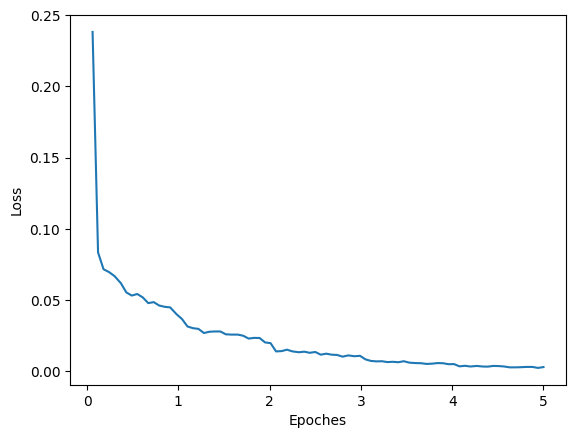

In [ ]:
plot_loss('/content/drive/MyDrive/RISE/bert-finetuned-ner-A_val/checkpoint-41025/trainer_state.json')

### Test set

#### Initializing the model

In [ ]:
# define training arguments
args = TrainingArguments(
    '/content/drive/MyDrive/RISE/bert-finetuned-ner-A',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32
)

#### Triggering fine-tuning

In [ ]:
# import data collator to pad inputs
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset_A['train'],
    eval_dataset=tokenized_dataset_A['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# start training
trainer.train()

# save the model
trainer.save_model('/content/drive/MyDrive/RISE/model_system_A')

Epoch,Training Loss,Validation Loss,Anim precision,Anim recall,Anim f1,Anim number,Bio precision,Bio recall,Bio f1,Bio number,Cel precision,Cel recall,Cel f1,Cel number,Dis precision,Dis recall,Dis f1,Dis number,Eve precision,Eve recall,Eve f1,Eve number,Food precision,Food recall,Food f1,Food number,Inst precision,Inst recall,Inst f1,Inst number,Loc precision,Loc recall,Loc f1,Loc number,Media precision,Media recall,Media f1,Media number,Myth precision,Myth recall,Myth f1,Myth number,Org precision,Org recall,Org f1,Org number,Per precision,Per recall,Per f1,Per number,Plant precision,Plant recall,Plant f1,Plant number,Time precision,Time recall,Time f1,Time number,Vehi precision,Vehi recall,Vehi f1,Vehi number,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.005300,0.082188,0.739266,0.740648,0.739956,3208,0.625000,0.625000,0.625000,16,0.714286,0.731707,0.722892,82,0.791317,0.744401,0.767142,1518,0.954802,0.960227,0.957507,704,0.640728,0.683746,0.661538,1132,0.538462,0.583333,0.560000,24,0.994999,0.992848,0.993922,24048,0.952991,0.973799,0.963283,916,0.735294,0.781250,0.757576,64,0.983071,0.982774,0.982923,6618,0.995242,0.993162,0.994201,10530,0.712999,0.619687,0.663076,1788,0.863469,0.809689,0.835714,578,0.805556,0.906250,0.852941,64,0.950526,0.944707,0.947607,0.983745
2,0.003200,0.101375,0.728655,0.776808,0.751961,3208,0.307692,0.500000,0.380952,16,0.795455,0.853659,0.823529,82,0.744472,0.798419,0.770502,1518,0.965714,0.960227,0.962963,704,0.668421,0.673145,0.670775,1132,0.529412,0.750000,0.620690,24,0.995088,0.994012,0.994550,24048,0.965217,0.969432,0.967320,916,0.750000,0.843750,0.794118,64,0.984885,0.984587,0.984736,6618,0.993352,0.993352,0.993352,10530,0.672241,0.674497,0.673367,1788,0.823729,0.840830,0.832192,578,0.787879,0.812500,0.800000,64,0.944972,0.951531,0.948240,0.983763
3,0.001800,0.109493,0.716292,0.794888,0.753546,3208,0.555556,0.625000,0.588235,16,0.765957,0.878049,0.818182,82,0.756250,0.797101,0.776139,1518,0.929730,0.977273,0.952909,704,0.656357,0.674912,0.665505,1132,0.529412,0.750000,0.620690,24,0.993440,0.994927,0.994183,24048,0.965142,0.967249,0.966194,916,0.777778,0.875000,0.823529,64,0.986569,0.976730,0.981625,6618,0.994683,0.994872,0.994777,10530,0.631529,0.743848,0.683102,1788,0.816949,0.833910,0.825342,578,0.794118,0.843750,0.818182,64,0.939653,0.955079,0.947303,0.983497
4,0.001300,0.116135,0.742891,0.781796,0.761847,3208,0.500000,0.750000,0.600000,16,0.727273,0.780488,0.752941,82,0.755000,0.795784,0.774856,1518,0.962751,0.954545,0.958631,704,0.653226,0.715548,0.682968,1132,0.500000,0.750000,0.600000,24,0.994839,0.993929,0.994384,24048,0.956897,0.969432,0.963124,916,0.736842,0.875000,0.800000,64,0.984541,0.981565,0.983051,6618,0.994117,0.994872,0.994494,10530,0.649849,0.720358,0.683289,1788,0.805825,0.861592,0.832776,578,0.823529,0.875000,0.848485,64,0.943271,0.954416,0.948811,0.983813
5,0.000700,0.124733,0.742673,0.789900,0.765559,3208,0.461538,0.750000,0.571429,16,0.680851,0.780488,0.727273,82,0.763224,0.798419,0.780425,1518,0.952778,0.974432,0.963483,704,0.668896,0.706714,0.687285,1132,0.529412,0.750000,0.620690,24,0.995089,0.994261,0.994675,24048,0.956897,0.969432,0.963124,916,0.750000,0.843750,0.794118,64,0.983651,0.981868,0.982759,6618,0.993738,0.994682,0.994210,10530,0.658031,0.710291,0.683163,1788,0.828283,0.851211,0.839590,578,0.783784,0.906250,0.840580,64,0.944601,0.954767,0.949657,0.983987


Overall results above (precision, recall, F1 and accuracy) show consistent metrics throughout the 5 epochs.
Metrics per NER category vary throughout, nevertheless it generally also improves with every epoch or stays within a similar range.

Plot the loss per epoch using the last checkpoint:

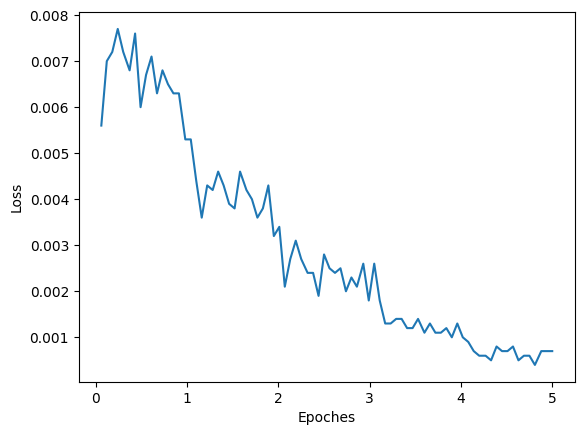

In [ ]:
plot_loss('/content/drive/MyDrive/RISE/bert-finetuned-ner-A/checkpoint-41025/trainer_state.json')

## System B: fine-tuning on 'bert-model-cased'


### Validation set

#### Initializing the model

In [ ]:
# define training arguments
args = TrainingArguments(
    '/content/drive/MyDrive/RISE/bert-finetuned-ner-B_val',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32
)

#### Triggering fine-tuning


First, I ran a training on the validation set to see how it performed, and 5 epochs seemed really good with a final accuracy of 99% (also seen in the plotted loss that it decreases per epoch). With this info, I moved to the test set with the same arguments.

In [ ]:
# import data collator to pad inputs
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset_B['train'],
    eval_dataset=tokenized_dataset_B['validation'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# start training
trainer.train()

-> I accidentally re-ran the cell below after training so I retrieved the results from the 'trainer_state.json' file, which is missing the training and validation loss individually and only shows the overall loss:

In [ ]:
import json, pandas as pd
pd.set_option('display.max_columns', None)

results = []

with open('/content/drive/MyDrive/RISE/bert-finetuned-ner-B_val/checkpoint-41025/trainer_state.json') as f:
    data = json.load(f)
    for info in data['log_history']:
        if info['epoch'] in [1,2,4,3,5] and info['step'] != 41000:
            results.append(info)

pd.DataFrame(results)

,epoch,eval_ANIM F1,eval_ANIM Number,eval_ANIM Precision,eval_ANIM Recall,eval_DIS F1,eval_DIS Number,eval_DIS Precision,eval_DIS Recall,eval_LOC F1,eval_LOC Number,eval_LOC Precision,eval_LOC Recall,eval_ORG F1,eval_ORG Number,eval_ORG Precision,eval_ORG Recall,eval_Overall_Accuracy,eval_Overall_F1,eval_Overall_Precision,eval_Overall_Recall,eval_PER F1,eval_PER Number,eval_PER Precision,eval_PER Recall,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,step
0,1.0,0.707972,2268,0.665890,0.755732,0.719038,3390,0.683316,0.758702,0.992532,15700,0.994627,0.990446,0.973219,5474,0.970567,0.975886,0.987787,0.951846,0.944434,0.959375,0.996339,15014,0.995742,0.996936,0.078603,50.6040,648.565,20.275,8205
1,2.0,0.739772,2268,0.708973,0.773369,0.736541,3390,0.715637,0.758702,0.990630,15700,0.991325,0.989936,0.970642,5474,0.962963,0.978444,0.988345,0.954939,0.949747,0.960187,0.996668,15014,0.997200,0.996137,0.079397,49.0750,668.772,20.907,16410
2,3.0,0.735461,2268,0.729402,0.741623,0.728147,3390,0.699457,0.759292,0.993248,15700,0.993374,0.993121,0.972953,5474,0.973309,0.972598,0.988550,0.955402,0.951462,0.959375,0.996407,15014,0.995479,0.997336,0.076825,49.2467,666.441,20.834,24615
3,4.0,0.749028,2268,0.734124,0.764550,0.737836,3390,0.716509,0.760472,0.992626,15700,0.990612,0.994650,0.975405,5474,0.972747,0.978078,0.988911,0.957239,0.952663,0.961860,0.996671,15014,0.996405,0.996936,0.082840,48.8624,671.683,20.998,32820
4,5.0,0.740643,2268,0.739666,0.741623,0.743041,3390,0.738068,0.748083,0.992936,15700,0.992115,0.993758,0.977600,5474,0.974582,0.980636,0.989156,0.958377,0.957144,0.959614,0.997069,15014,0.997202,0.996936,0.086462,48.9161,670.944,20.975,41025


Plot the loss per epoch using the last checkpoint:

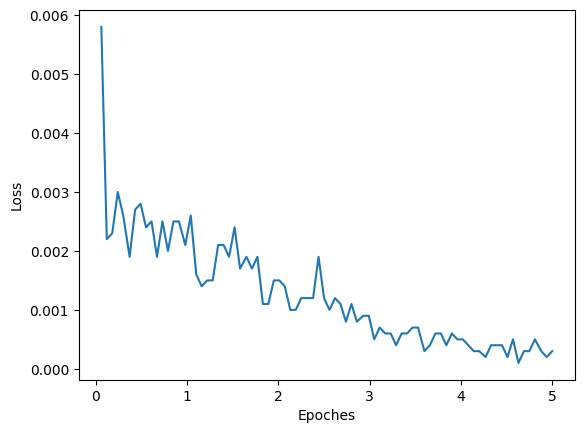

In [ ]:
plot_loss('/content/drive/MyDrive/RISE/bert-finetuned-ner-B_val/checkpoint-41025/trainer_state.json')

### Test set

#### Initializing the model

In [ ]:
# define training arguments
args = TrainingArguments(
    '/content/drive/MyDrive/RISE/bert-finetuned-ner-B',
    evaluation_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32
)

#### Triggering fine-tuning

In [ ]:
# import data collator to pad inputs
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_dataset_B['train'],
    eval_dataset=tokenized_dataset_B['test'],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# start training from checkpoint as it stopped mid 2nd epoch
trainer.train()

# save the model
trainer.save_model('/content/drive/MyDrive/RISE/model_system_B')

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Anim precision,Anim recall,Anim f1,Anim number,Dis precision,Dis recall,Dis f1,Dis number,Loc precision,Loc recall,Loc f1,Loc number,Org precision,Org recall,Org f1,Org number,Per precision,Per recall,Per f1,Per number,Overall Precision,Overall Recall,Overall F1,Overall Accuracy
1,0.020700,0.029400,0.733289,0.683915,0.707742,3208,0.727273,0.695652,0.711111,1518,0.995322,0.990935,0.993124,24048,0.980700,0.982774,0.981736,6618,0.993930,0.995252,0.994590,10530,0.967122,0.959540,0.963316,0.989363
2,0.009900,0.037761,0.705245,0.771197,0.736748,3208,0.743396,0.778656,0.760618,1518,0.995501,0.993679,0.994589,24048,0.979298,0.986401,0.982836,6618,0.994484,0.992972,0.993727,10530,0.962275,0.969818,0.966032,0.989858
3,0.004800,0.045139,0.723563,0.784913,0.752990,3208,0.746250,0.786561,0.765876,1518,0.994925,0.994511,0.994718,24048,0.983631,0.980659,0.982143,6618,0.995438,0.994682,0.995060,10530,0.964402,0.971038,0.967708,0.990045
4,0.001800,0.058172,0.759494,0.748130,0.753769,3208,0.773609,0.787879,0.780679,1518,0.995500,0.993596,0.994547,24048,0.981890,0.983076,0.982483,6618,0.994496,0.995252,0.994874,10530,0.969567,0.968512,0.969039,0.990261
5,0.001100,0.066106,0.733053,0.761845,0.747172,3208,0.759142,0.793149,0.775773,1518,0.995753,0.994511,0.995132,24048,0.982202,0.983983,0.983092,6618,0.994687,0.995632,0.995159,10530,0.966427,0.970341,0.968380,0.990124


Checkpoint destination directory /content/drive/MyDrive/RISE/bert-finetuned-ner-B/checkpoint-8205 already exists and is non-empty.Saving will proceed but saved results may be invalid.


As with the validation set, overall results above (precision, recall, F1 and accuracy) show consistent metrics throughout the 5 epochs.
Metrics per NER category vary throughout, nevertheless it generally also improves with every epoch or stays within a similar range.

Plot the loss per epoch using the last checkpoint:

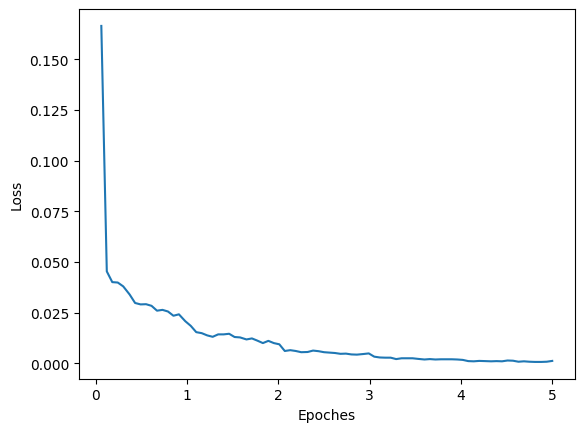

In [ ]:
plot_loss('/content/drive/MyDrive/RISE/bert-finetuned-ner-B/checkpoint-41025/trainer_state.json')

## Uploading the models to the HuggingFace Hub
I saved the files instead of uploading to the hub, so now I'm uploading them for easier use.

In [1]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from huggingface_hub import HfApi
api = HfApi()

# system A
api.upload_folder(
    folder_path="/content/drive/MyDrive/RISE/model_system_A",
    repo_id="johnhandleyd/RISE_system_A",
    repo_type="model",
)

# system B
api.upload_folder(
    folder_path="/content/drive/MyDrive/RISE/model_system_B",
    repo_id="johnhandleyd/RISE_system_B",
    repo_type="model",
)

# Testing the models with custom input

In [ ]:
# import pipeline
from transformers import pipeline

In [ ]:
# an array of phrases
phrases = [
    "I'm John and this is my assignment for the Research Engineer position at RISE.",
    "The Eurasian otter has a diet mainly of fish, and is strongly territorial.",
    "OpenAI has developed several large language models, advanced image generation models, and previously, also open-source models.",
    "In November 2022, reports began circulating that Ryan Reynolds was interested in purchasing ownership of the Ottawa Senators, which were to be sold by the estate of the late Eugene Melnyk.",
    "The farthest planet from Earth discovered by the unaided human eye, Saturn has been known since ancient times. The planet is named for the Roman god of agriculture and wealth, who was also the father of Jupiter.",
    "Some scholars suggested that Poseidon was probably a Pelasgian god or a god of the Minyans.",
    "There are effective treatments and vaccines against some of the main bacterial causes of meningitis. However, meningitis remains a significant threat around the world.",
    "I wish you all a very merry Christmas!"
]

In [ ]:
def print_results(predictions, phrases=phrases):
    for phrase, pred in zip(phrases, predictions):
        print('\nSentence: ', phrase)
        for entity in pred:
            print(f'Prediction: word "{entity["word"]}" predicted as "{entity["entity_group"]}" with score {entity["score"]}.')

## System A

In [24]:
model_checkpoint_A = 'johnhandleyd/RISE_system_A'
token_classifier_A = pipeline(
    "token-classification", model=model_checkpoint_A, aggregation_strategy='simple'
)

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
pred_A = token_classifier_A(phrases)
print_results(pred_A)


Sentence:  I'm John and this is my assignment for the Research Engineer position at RISE.
Prediction: word "John" predicted as "PER" with score 0.9998311996459961.
Prediction: word "RISE" predicted as "ORG" with score 0.9999911189079285.

Sentence:  The Eurasian otter has a diet mainly of fish, and is strongly territorial.
Prediction: word "Eurasian otter" predicted as "ANIM" with score 0.9999656677246094.

Sentence:  OpenAI has developed several large language models, advanced image generation models, and previously, also open-source models.
Prediction: word "OpenAI" predicted as "ORG" with score 0.999995231628418.

Sentence:  In November 2022, reports began circulating that Ryan Reynolds was interested in purchasing ownership of the Ottawa Senators, which were to be sold by the estate of the late Eugene Melnyk.
Prediction: word "Ryan Reynolds" predicted as "PER" with score 0.9999987483024597.
Prediction: word "Ottawa Senators" predicted as "ORG" with score 0.9999919533729553.
Predic

In the results above we can see an overall good performance with high scores; for example, in the first phrase, it correctly identifies "John" as a name and "RISE" as an organization, and in the last sentence, it detects "Christmas" as time. Another interesting case is the 5th sentence, where it correctly distinguishes between celestial and mythology when it comes to Roman and Jupiter, as the context indicates mythology and not celestial for those two words, whereas it's more celestially related in the first two words ("Earth" and "Saturn").

Nevertheless, there are some misses. For instance, in the second sentence it did not predict "fish" as food, and in the 6th sentence, the tokenizer splits "Minyans" making it harder to predict as a whole. In the 7th sentence, "meningitis" is not detected as disease, and "bacteria" is wrongly given the DIS tag.

These errors, nonetheless, could've been avoided by setting a minimum score threshold of above, per instance, 75%. Thus, then, they wouldn't have been wrongly tagged (though there can be some misses, like with "Minyans", which needs the correct "MYTH" tag).

## System B

In [22]:
model_checkpoint_B = 'johnhandleyd/RISE_system_B'
token_classifier_B = pipeline(
    "token-classification", model=model_checkpoint_B, aggregation_strategy='simple'
)

config.json:   0%|          | 0.00/1.84k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/431M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/669k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [ ]:
pred_B = token_classifier_B(phrases)
print_results(pred_B)


Sentence:  I'm John and this is my assignment for the Research Engineer position at RISE.
Prediction: word "John" predicted as "PER" with score 0.9998441934585571.
Prediction: word "RISE" predicted as "ORG" with score 0.9999856352806091.

Sentence:  The Eurasian otter has a diet mainly of fish, and is strongly territorial.
Prediction: word "Eurasian otter" predicted as "ANIM" with score 0.9999328255653381.

Sentence:  OpenAI has developed several large language models, advanced image generation models, and previously, also open-source models.
Prediction: word "OpenAI" predicted as "ORG" with score 0.9997822642326355.

Sentence:  In November 2022, reports began circulating that Ryan Reynolds was interested in purchasing ownership of the Ottawa Senators, which were to be sold by the estate of the late Eugene Melnyk.
Prediction: word "Ryan Reynolds" predicted as "PER" with score 0.9999947547912598.
Prediction: word "Ottawa Senators" predicted as "ORG" with score 0.9999687075614929.
Predi

Results for system B, which only includes tags "ANIM", "DIS", "ORG", "LOC" and "PER" performs similarly as System A, excluding those tags that were not included in this training (e.g., CEL and MYTH).

The only differences are that it correctly detects "meningitis" as a disease, and that it doesn't make the mistake System A made by tagging part of the word "Minyans" as "LOC".

Thus, for the tags it was trained with, it performed perfectly!

## Test any input!

Update the variable 'test_phrase' to check any phrase you like!

Make sure you've ran the previous sections and indicated the path for the model.

In [25]:
# system A
test_phrase = "I'm John and this is my assignment for the Research Engineer position at RISE."
token_classifier_A(test_phrase)

[{'entity_group': 'PER',
  'score': 0.9998312,
  'word': 'John',
  'start': 4,
  'end': 8},
 {'entity_group': 'ORG',
  'score': 0.9999911,
  'word': 'RISE',
  'start': 73,
  'end': 77}]

In [23]:
# system B
test_phrase = "I'm John and this is my assignment for the Research Engineer position at RISE."
token_classifier_B(test_phrase)

[{'entity_group': 'PER',
  'score': 0.9998442,
  'word': 'John',
  'start': 4,
  'end': 8},
 {'entity_group': 'ORG',
  'score': 0.99998564,
  'word': 'RISE',
  'start': 73,
  'end': 77}]